# Preparing Target Data

MendelImpute accepts [VCF](https://samtools.github.io/hts-specs/VCFv4.3.pdf) and [PLINK](https://www.cog-genomics.org/plink2/formats#bed) files. Please make sure the following are true:

+ VCF file ends in `.vcf` or `.vcf.gz` (phased or unphased and may contain missing data)
+ For PLINK files, all trios (`.bim`, `.bed`, `.fam`) are present in the same directory
+ Each file contains only 1 (non-sex) chromosome
+ Every record (SNP) is present in the reference panel. If this is untrue, you must [match markers in 2 VCF files](https://openmendel.github.io/VCFTools.jl/dev/man/conformgt/). 
+ Given a SNP, its CHROM, POS, REF, and  ALT fields are the same in target data and reference panel. MendelImpute use SNP position internally to align markers. Note this is not explicitly checked. 
+ The position of every SNP is unique: so multiallelic markers should be excluded instead of split (this requirement will eventually be lifted). 

# Preparing Reference Haplotype Panel

Reference samples must all be phased and contain no missing genotypes. Reference VCF panels must be compressed into `.jlso` format first using the [compress_haplotypes](https://OpenMendel.github.io/MendelImpute.jl/dev/man/api/#MendelImpute.compress_haplotypes) function. One must specify `d`: the maximum number of unique haplotypes per window. Larger `d` slows down computation, but increases accuracy. For most purposes, we recommend $d \approx 1000$. 

# Detailed Example

We use the [1000 genomes chromosome 22](http://bochet.gcc.biostat.washington.edu/beagle/1000_Genomes_phase3_v5a/b37.vcf/) as an example. As show below, this data contains 424147 SNPs and 2504 samples.

In [1]:
# load necessary packages in Julia
using VCFTools
using MendelImpute
using VCFTools
using Random

# compute simple summary statistics
data = "chr22.1kg.phase3.v5a.vcf.gz"
@show nrecords(data)
@show nsamples(data);

nrecords(data) = 424147
nsamples(data) = 2504


More summary statistics can be computed using the [gtstats](https://openmendel.github.io/VCFTools.jl/dev/man/api/#VCFTools.gtstats) function in `VCFTools.jl`, with example usage [here](https://openmendel.github.io/VCFTools.jl/dev/man/summaryinfo/#Summary-statistics).

## Step 1: generating realistic reference and target data 

First we generate a reference panel and imputation target based on the 1000 genomes data. Specifically, we divide the 1000 genomes chromosome 22 data so that 
+ 100 samples are randomly selected as imputation targets, where
    - 100k SNPs with minor allele frequency $\ge 0.05$ are randomly selected to be the typed positions. 
    - 0.1% of typed SNPs are masked (mimicking genotyping errors)
    - Genotypes are unphased
+ The remaining 2404 samples are used as reference haplotypes. 
+ SNPs with duplicate positions are filtered out.
+ All multiallelic markers are filtered out.

**Instruction: execute the code below in a Julia session or a Jupyter notebook:**

In [1]:
# set random seed for reproducibility
Random.seed!(2020)

# download example data 
data = "chr22.1kg.phase3.v5a.vcf.gz"
if !isfile(data) 
    download("http://bochet.gcc.biostat.washington.edu/beagle/1000_Genomes_phase3_v5a/b37.vcf/chr22.1kg.phase3.v5a.vcf.gz")
end

# remove SNPs with the same positions, keep all samples, save result into new file
SNPs_to_keep = .!find_duplicate_marker(data) 
@time VCFTools.filter(data, SNPs_to_keep, 1:nsamples(data), des = "chr22.uniqueSNPs.vcf.gz")

# summarize data
total_snps, samples, _, _, _, maf_by_record, _ = gtstats("chr22.uniqueSNPs.vcf.gz")

# generate target file with 100 samples and 100k snps with maf>0.05
n = 100
p = 100000
record_idx = falses(total_snps)
large_maf = findall(x -> x > 0.05, maf_by_record)  
Random.shuffle!(large_maf)
record_idx[large_maf[1:p]] .= true
sample_idx = falses(samples)
sample_idx[1:n] .= true
Random.shuffle!(sample_idx)
@time VCFTools.filter("chr22.uniqueSNPs.vcf.gz", record_idx, sample_idx, 
    des = "target.chr22.typedOnly.vcf.gz", allow_multiallelic=false)

# unphase and mask 0.1% entries in target file
masks = falses(p, n)
missingprop = 0.001
for j in 1:n, i in 1:p
    rand() < missingprop && (masks[i, j] = true)
end
@time mask_gt("target.chr22.typedOnly.vcf.gz", masks, 
    des="target.chr22.typedOnly.masked.vcf.gz", unphase=true)

# generate target panel with all snps (this file contains true phase and genotypes)
@time VCFTools.filter("chr22.uniqueSNPs.vcf.gz", 1:total_snps, 
    sample_idx, des = "target.chr22.full.vcf.gz", allow_multiallelic=false)

# generate reference panel with 2404 samples
@time VCFTools.filter("chr22.uniqueSNPs.vcf.gz", 1:total_snps, .!sample_idx, 
    des = "ref.chr22.excludeTarget.vcf.gz", allow_multiallelic=false)

┌ Info: Precompiling MendelImpute [e47305d1-6a61-5370-bc5d-77554d143183]
└ @ Base loading.jl:1278
finding duplicate markers...100%|███████████████████████| Time: 0:03:56
filtering vcf file...100%|██████████████████████████████| Time: 0:04:46


292.131527 seconds (3.20 G allocations: 301.789 GiB, 7.89% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:04:02
filtering vcf file...100%|██████████████████████████████| Time: 0:03:59


244.425505 seconds (3.18 G allocations: 301.694 GiB, 9.69% gc time)
  1.935526 seconds (20.00 M allocations: 1.491 GiB, 6.33% gc time)


filtering vcf file...100%|██████████████████████████████| Time: 0:04:10


255.505399 seconds (3.27 G allocations: 317.749 GiB, 9.95% gc time)


filtering vcf file...100%|██████████████████████████████| Time: 0:07:27


453.383147 seconds (6.16 G allocations: 566.535 GiB, 10.16% gc time)


### Output explanation:

You just generated reference and target VCF files:

+ `ref.chr22.excludeTarget.vcf.gz`: Reference haplotype panel with 2404 samples
+ `target.chr22.typedOnly.masked.vcf.gz`: Imputation target file containing 100 samples at 100k SNPs. All genotypes are unphased and contains 0.1% missing data. 

You also generated/downloaded:

+ `chr22.1kg.phase3.v5a.vcf.gz`: The original chromosome 22 data downloaded from Beagle's website.
+ `chr22.uniqueSNPs.vcf.gz`: This is the original chromosome 22 data excluding duplicate records (SNPs) by checking marker positions. The first SNP is included but all subsequent SNPs are removed. 
+ `target.chr22.full.vcf.gz`: The complete data for imputation target, used for checking imputation accuracy. All genotypes are phased and non-missing. 
+ `target.chr22.typedOnly.vcf.gz`: Complete target data on just the typed SNPs. All genotypes are phased and non-missing. Just by-producted for generating other files; not used for anything downstream.

## Step 2: generating `.jlso` compressed reference panel

MendelImpute requires one to pre-process the reference panel for faster reading. This is achieved via the [compress_haplotypes](https://openmendel.github.io/MendelImpute.jl/dev/man/api/#MendelImpute.compress_haplotypes) function.

In [2]:
# load necessary packages in Julia
using MendelImpute

max_d = 1000 # maximum number of unique haplotypes per window
reffile = "ref.chr22.excludeTarget.vcf.gz"
tgtfile = "target.chr22.typedOnly.masked.vcf.gz"
outfile = "ref.chr22.maxd1000.excludeTarget.jlso"
@time compress_haplotypes(reffile, tgtfile, outfile, max_d)

importing reference data...100%|████████████████████████| Time: 0:02:00


295.546081 seconds (2.09 G allocations: 209.215 GiB, 10.53% gc time)


## Step 3: Run imputation and phasing

The [phase](https://openmendel.github.io/MendelImpute.jl/dev/man/api/#MendelImpute.phase) function will perform imputation and phasing. By default, all output genotypes will be phased and non-missing. A list of optional inputs can be found in the [API](https://openmendel.github.io/MendelImpute.jl/dev/man/api/#MendelImpute.phase).

In [3]:
# note: run twice for more accurate timing
reffile = "ref.chr22.maxd1000.excludeTarget.jlso" # jlso reference file
tgtfile = "target.chr22.typedOnly.masked.vcf.gz"  # target genotype file
outfile = "mendel.imputed.chr22.vcf.gz"           # output file name
phase(tgtfile, reffile, outfile);

Number of threads = 1
Importing reference haplotype data...


Computing optimal haplotypes...100%|████████████████████| Time: 0:00:20


Total windows = 1634, averaging ~ 508 unique haplotypes per window.

Timings: 
    Data import                     = 9.88384 seconds
        import target data             = 1.77236 seconds
        import compressed haplotypes   = 8.11149 seconds
    Computing haplotype pair        = 20.3066 seconds
        BLAS3 mul! to get M and N      = 1.06045 seconds per thread
        haplopair search               = 18.8367 seconds per thread
        initializing missing           = 0.101118 seconds per thread
        allocating and viewing         = 0.276894 seconds per thread
        index conversion               = 0.0199662 seconds per thread
    Phasing by win-win intersection = 4.32098 seconds
        Window-by-window intersection  = 0.53913 seconds per thread
        Breakpoint search              = 3.53301 seconds per thread
        Recording result               = 0.23443 seconds per thread
    Imputation                     = 3.40132 seconds
        Imputing missing               = 0.4

The `;` hides the output, or else the screen will be too jammed. 

!!! note

    To run MendelImpute in parallel, type `export JULIA_NUM_THREADS=4` **before** starting Julia or Jupyter notebooks. See Performance Gotchas #1 on the left for details.

## Step 3.5: (only for simulated data) check imputation accuracy

Since we simulated data, we can check imputation accuracy.

In [4]:
X_truth  = convert_gt(Float64, "target.chr22.full.vcf.gz")    # import true genotypes
X_mendel = convert_gt(Float64, "mendel.imputed.chr22.vcf.gz") # import imputed genotypes
n, p = size(X_mendel)
println("error overall = ", sum(X_mendel .!= X_truth) / n / p)

error overall = 0.005273778941849357


Thus, we are looking at about 5 imputation error out of every 1000 SNPs. 

## Post-imputation: per-SNP Imputation Quality Score

Consider the observed genotype $x_{ij} \in [0, 2] \cup \{missing\}$ at SNP $i$ of sample $j$ and the corresponding imputed genotype $g_{ij}$ derived from the two extended haplotypes of $j$. If $S_i$ denotes the set of individuals with observed genotypes at the SNP, then MendelImpute's quality score $q_i$ for the SNP is defined as

$$q_i = 1 - \frac{1}{|S_i|}\sum_{j \in S_i} \left(\frac{x_{ij} - g_{ij}}{2}\right)^2.$$

Note that $0 \le q_i \le 1$ and that the larger the quality score, the more confidence in the imputed values. Because $q_i$ can only be computed for the typed SNPs, an untyped SNP is assigned the average of the quality scores for its two closest flanking typed SNPs.

To extract this score from a VCF file, one can do:

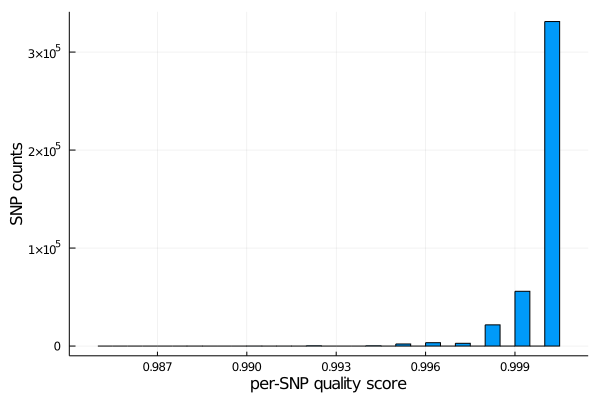

In [8]:
using GeneticVariation, Plots
reader = VCF.Reader(openvcf(outfile, "r"))
snpscores = Vector{Float64}(undef, nrecords(outfile))

# loop over SNPs
for (i, record) in enumerate(reader)
    snpscores[i] = parse(Float64, VCF.info(record)[1].second)
end
close(reader)

# plot histogram of SNP scores
histogram(snpscores, label=:none, xlabel="per-SNP quality score", 
    ylabel="SNP counts", bins=30)

**Conclusion:** Most SNPs are well imputed (quality score close to $1.0$), but a few have subpar quality score (e.g. below $0.999$). We recommend such SNPs to be [filtered out](https://openmendel.github.io/VCFTools.jl/dev/man/filter/#Subsetting-VCF-files-using-array-masks). 

!!! note

    The popular correlation metric $r^2$ such as [this one](https://genome.sph.umich.edu/wiki/Minimac3_Info_File#Rsq) is NOT a good metric for measuring imputation accuracy under MendelImpute's model, because all imputed SNPs will have $r^2 = 1$. For details, please see our paper. 

## Post-imputation: per-sample Imputation Quality score

MendelImpute also computes a rough quality score (file ending in `sample.error`) for measuring how well each sample is imputed. This value is the sum of the least squares error for all typed SNPs scaled by the total number of observed SNPs, similar to the per-SNP quality score. A value of 1.0 is best, and 0 is worst. 

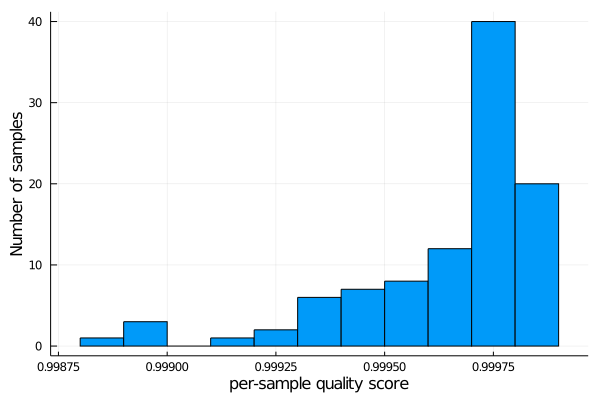

In [7]:
using CSV
quality = CSV.read("mendel.imputed.chr22.sample.error") # import quality score 

# visualize error distribution
histogram(quality[:error], label=:none, xlabel="per-sample quality score",
    ylabel="Number of samples") 

**Conclusion:** Most samples are well imputed (e.g. score close to 1), but some samples are indeed poorly imputed. From the histogram, we can safely [filtered out](https://openmendel.github.io/VCFTools.jl/dev/man/filter/#Subsetting-VCF-files-using-array-masks) samples with score $< 0.999$ as that would remove poorly imputed individuals without reducing sample size too much.